# [Client Presentation](https://docs.google.com/presentation/d/1PWTjptQ0Ib4KMdgFiKt7bZBNwjfqjiu3T7HEf4oOGvI/edit?usp=sharing)

In [15]:
# Import necessary libraries

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')

In [16]:
class Final:
    
    def __init__(self, excel_file = None):
        self.excel_file = excel_file
        
    def read_excel(self):
        purchase_exit_survey_data_df = pd.read_excel(self.excel_file, sheet_name = 'Purchase Exit Survey Data', header=[0,1,2,3,4], index_col=[0,1], engine='openpyxl')
        airings_df = pd.read_excel(self.excel_file, sheet_name = 'Airings')
        lookup_df = pd.read_excel(self.excel_file, sheet_name = 'Lookup',header=1)
        return purchase_exit_survey_data_df, airings_df, lookup_df
    
    def prepare_data(self):
        df1, df2, df3 = self.read_excel()
        
        # Preare df1/purchase_exit_survey_data_df for use
        
        # Reformat purchase_exit_survey_data_df
        df1 = df1.stack().stack().stack().stack()
        # Set Up Names inpurchase_exit_survey_data_df
        df1.index.set_names(['Campaign_Type','TV_Network','Submitted_Application_Num','Month', 'Quarter','Year'],level=[0,1,2,3,4,5], inplace=True)
        # Reset index in purchase_exit_survey_data_df
        df1 = df1.reset_index()
        # Change last column name to Value in purchase_exit_survey_data_df
        df1 = df1.rename(columns={'Submitted Application Timestamp':'Value'})
        # Change Year to Int
        df1['Year'] = pd.to_datetime(df1.Year, format='%Y').dt.year
        # Change Month Column to Ints
        df1['Month'] = pd.to_datetime(df1.Month, format='%B').dt.month
        # Finalize purchase_exit_survey_data_df columns
        df1 = df1[['TV_Network','Year','Quarter','Month','Submitted_Application_Num','Value']]
        
        # Prepare df2/airings_df for use
        
        # Change Date/Time ET Column Name to Datetime
        df2 = df2.rename(columns={'Date/Time ET': 'Datetime'})
        df2['Year'] = pd.DatetimeIndex(df2['Datetime']).year
        df2['Month'] = pd.DatetimeIndex(df2['Datetime']).month
        
        # Prepare df3/lookup for use
        
        # Make firt column lowercase
        df3['Exit Survey'] = df3['Exit Survey'].str.lower()
        
        return df1, df2, df3
    
    def get_monthly_stats(self):
        df1, df2, df3 = self.prepare_data()
        
        # Compute Visits Per Month
        visits_per_month = df1.groupby(['Year','Quarter','Month','TV_Network'])['Value'].sum()
        visits_per_month = visits_per_month.to_frame()
        visits_per_month = visits_per_month.reset_index()
        visits_per_month = visits_per_month.rename(columns = {'Value':'Purchases'})
        
        # Merge visits_per_month to Lookup Table
        visits_per_month = pd.merge(visits_per_month, df3[['Exit Survey','Airings']],left_on= ['TV_Network'], right_on = ['Exit Survey'], how='left')
        
        # Compute Spend and Lift Per Month
        lift_spend_df = df2.groupby(['Year','Month','Network'])[['Spend','Lift']].apply(sum)
        lift_spend_df = lift_spend_df.reset_index()
        
        # Merge Spend and Lift to Lookup Tab;e
        lift_spend_df = pd.merge(lift_spend_df, df3[['Exit Survey','Airings']],left_on= ['Network'], right_on = ['Airings'], how='left')
        
        # Merge visit data and lift/spend data
        monthly_stats = pd.merge(visits_per_month, lift_spend_df, on=['Year','Month','Exit Survey'], how='outer')
        monthly_stats['network_name'] = np.where(monthly_stats.TV_Network.isnull(),monthly_stats.Network,monthly_stats.TV_Network)
        monthly_stats = monthly_stats[['Year','Quarter','Month','TV_Network','Network','network_name','Purchases','Spend','Lift']]
        monthly_stats = monthly_stats[monthly_stats.Year.notna()]
        
        
        
        return monthly_stats
    
    def get_metrics(self):
        # Get Monthly Stats Df
        monthly_stats = self.get_monthly_stats()
        
        # Compute Cost Per Visitor
        monthly_stats['cpv'] = np.where(monthly_stats.Spend.isnull(),0, np.where((monthly_stats.Lift.isnull()),0,round((monthly_stats.Spend/monthly_stats.Lift),2)))
        
        # Compute Conversion Rate 
        monthly_stats['conversion_rate'] = np.where(monthly_stats.Purchases.isnull(),0, np.where((monthly_stats.Lift.isnull()),100,(monthly_stats['Purchases']/monthly_stats['Lift'])*100))
        
        # Compute Cost Per Acquisition
        monthly_stats['cpa'] = np.where(monthly_stats.Spend.isnull(),0, np.where((monthly_stats.Purchases.isnull()),1000000,(monthly_stats.Spend/monthly_stats.Purchases)))
        
        return monthly_stats
    
    def print_visuals(self, metrics):
        df = self.get_metrics()
    
        year_mons = []

        # Get number of plots need (one for each month of each year recorded)
        for year in monthly_stats['Year'].unique():
            for month in df[df['Year'] == year]['Month'].unique():
                year_mons.append([year, month])
            
        for metric in metrics:
            for i in range(len(year_mons)):
                # Create dataframe for plot
                vis_df = df[(df['Year'] == year_mons[i][0]) & (df['Month'] == year_mons[i][1])]
                # Sort values by metric
                vis_df = vis_df.sort_values(metric)
                # Format Spend
                vis_df['Spend'] = round(vis_df['Spend'],2)
                vis_df['Spend'] = vis_df['Spend'].map('{:,.2f}'.format)
                vis_df['Spend'] = vis_df.Spend.map(lambda x: '$' + x if x != 'nan' else x)
                # Format Purchases
                vis_df.Purchases = vis_df.Purchases.astype(str).replace('\.0', '', regex=True)
                # Format Lift
                vis_df['Lift'] = vis_df['Lift'].map('{:,.0f}'.format)
                # Clean Network Names
                vis_df.network_name = vis_df.network_name.map(lambda x: x.replace("_"," "))
                vis_df.network_name = vis_df.network_name.map(lambda x: x.title())
                labels = vis_df.network_name
                x_axis = range(len(labels))
                # Create Plot
                fig = plt.figure(figsize = (30,35))
                gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.5]) 
                ax1 = fig.add_subplot(gs[0])
                
                # Adjust Y Axis Size
                if metric != 'conversion_rate':
                    real_metrics = vis_df[vis_df[metric] != 1000000]
                    max_real_metric = max(real_metrics[metric])
                else:
                    real_metrics = vis_df[vis_df[metric] != 100]
                    max_real_metric = max(real_metrics[metric])
                plt.ylim(0, max_real_metric*1.5)
                
                
                # Customize Palette for Each Metric
                if metric == 'cpv':
                    palette_color = ['orange']
                elif metric == 'cpa':
                    palette_color = ['mediumslateblue']
                elif metric =='conversion_rate':
                    palette_color = ['mediumspringgreen']
                else:
                    palette_color = ['red']
                # Plot data
                sns.barplot(x='network_name',y=metric, data=vis_df, palette = palette_color)
                # CAP All Metric Name
                cap_metric = metric.replace("_"," ")
                cap_metric = cap_metric.upper()
                if metric == 'conversion_rate':
                    cap_metric = cap_metric +" %"
                # Get Month Name (String)
                datetime_object = datetime.datetime.strptime(str(year_mons[i][1]), "%m")
                month_name = datetime_object.strftime("%B")
                # Title
                plt.title(cap_metric +' - ' + month_name + ', ' + str(year_mons[i][0]) , fontsize=35)
                # X Axis Label
                plt.xlabel('Network', fontsize=24)
                # Y Axis Label
                plt.ylabel(cap_metric, fontsize=24)
                # X Ticks
                plt.xticks(x_axis, [textwrap.fill(label, 12) for label in labels],fontsize=18, rotation=60)
                plt.yticks(fontsize=18)
                
                # Set df next to plot
                ax2 = fig.add_subplot(gs[1])
                bbox=[0, 0, 1, 1]
                ax2.axis('off')
                
                # Create DF
                if metric == 'cpv':
                    plot_df = vis_df[['network_name', 'cpv','Spend','Lift']]
                    # Format CPV
                    plot_df['cpv'] = plot_df['cpv'].map('{:,.2f}'.format)
                    plot_df['cpv'] = plot_df.cpv.map(lambda x: '$' + x)
                    plot_df = plot_df.rename(columns={'network_name':'Network', 'cpv':'Cost Per Vist'})
                    plot_df = plot_df.reset_index(drop=True)
                elif metric == 'cpa':
                    plot_df = vis_df[['network_name', 'cpa','Spend','Purchases']]
                    # Format CPA
                    plot_df['cpa'] = plot_df['cpa'].map('{:,.2f}'.format)
                    plot_df['cpa'] = plot_df.cpa.map(lambda x: '$' + x)
                    plot_df = plot_df.rename(columns={'network_name':'Network', 'cpa':'Cost Per Acquisition'})
                    plot_df = plot_df.reset_index(drop=True)
                elif metric == 'conversion_rate':
                    plot_df = vis_df[['network_name', 'conversion_rate','Purchases','Lift']]
                    plot_df['conversion_rate'] = plot_df['conversion_rate'].apply(lambda x: round(x,2))
                    plot_df['conversion_rate'] = plot_df.conversion_rate.map(lambda x: str(x)+'%' if str(x) != 'nan' else x)
                    plot_df = plot_df.rename(columns={'network_name':'Network', 'conversion_rate':'Conversion Rate'})
                    plot_df = plot_df.reset_index(drop=True)
                else:
                    plot_df = vis_df[['network_name', metric,'Spend','Purchases']]
                    plot_df = plot_df.reset_index(drop=True)
                
                mpl_table = ax2.table(cellText = plot_df.values, rowLabels = plot_df.index,bbox=bbox, colLabels=plot_df.columns, cellLoc = 'center', rowLoc = 'center',loc='bottom')
                mpl_table.set_fontsize(20)
                
                
                

In [17]:
test = Final('Analyst_Dataset.xlsx')

In [18]:
monthly_stats = test.get_metrics()
monthly_stats.head()

,Year,Quarter,Month,TV_Network,Network,network_name,Purchases,Spend,Lift,cpv,conversion_rate,cpa
0,2017,Q3,9,aapka_colors,NaN,aapka_colors,1.0,NaN,NaN,0.00,100.000000,0.000
1,2017,Q3,9,baby_first,NaN,baby_first,1.0,NaN,NaN,0.00,100.000000,0.000
2,2017,Q3,9,bloomberg,BLOM,bloomberg,1.0,4966.72,199.0,24.96,0.502513,4966.720
3,2017,Q3,9,cbs_sports,NaN,cbs_sports,1.0,NaN,NaN,0.00,100.000000,0.000
4,2017,Q3,9,cnbc,CNBC,cnbc,5.0,6481.42,406.0,15.96,1.231527,1296.284


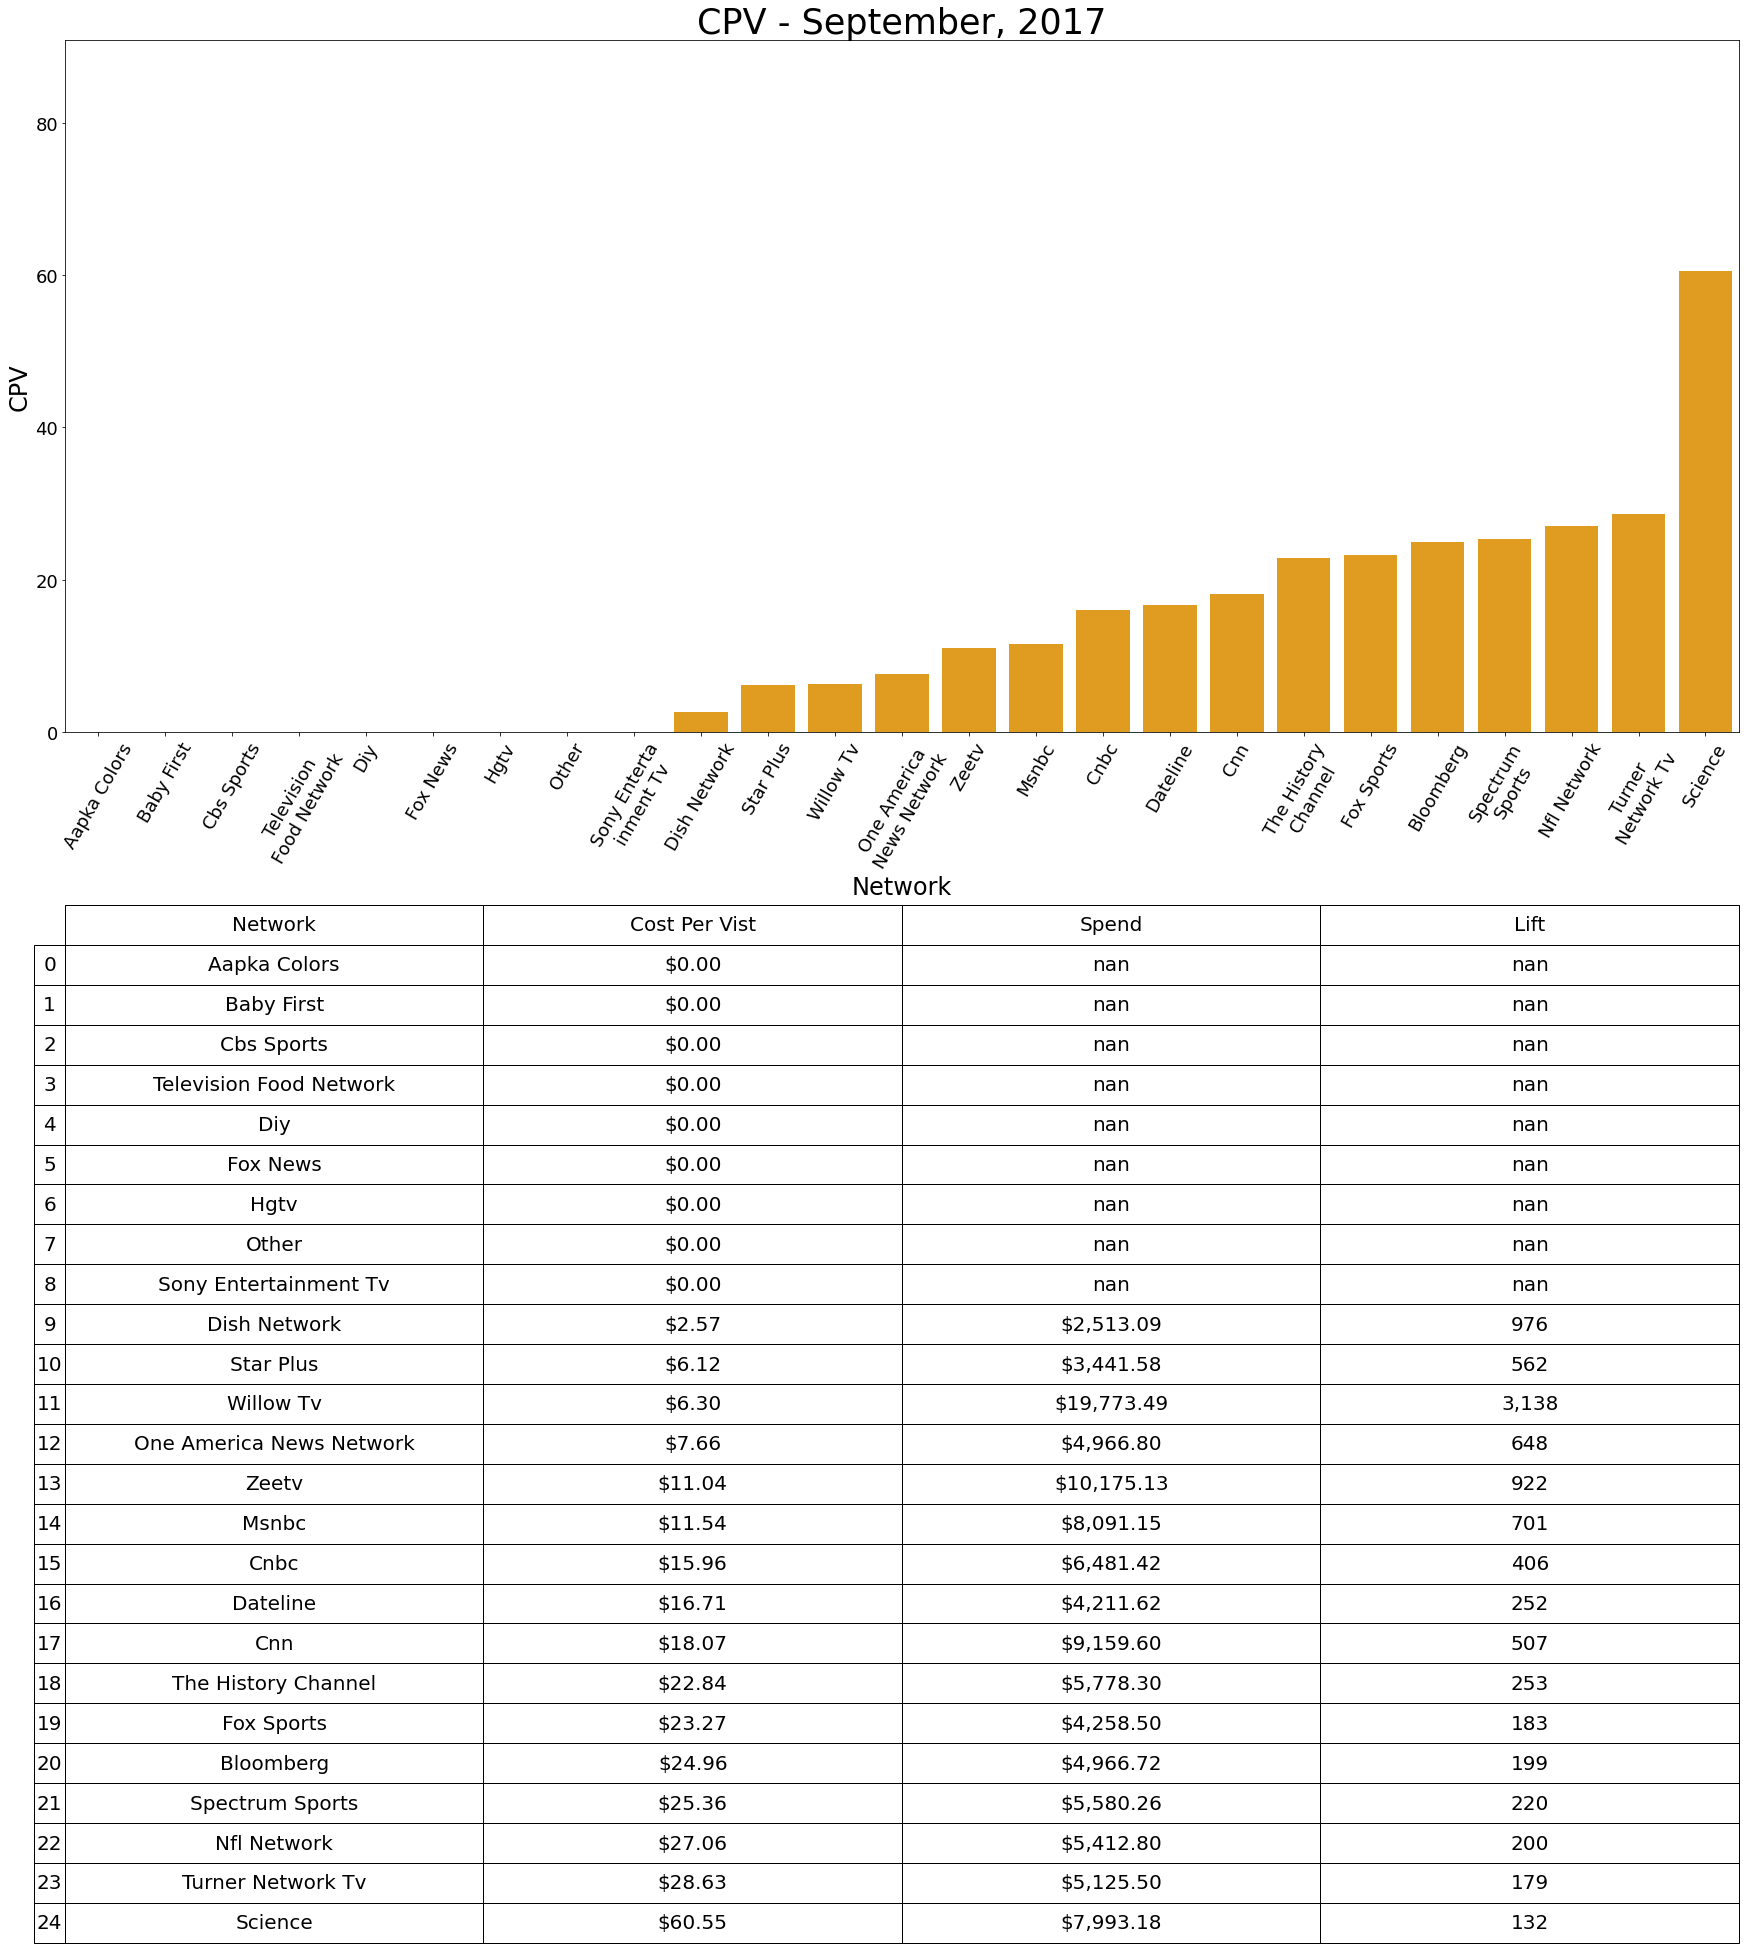

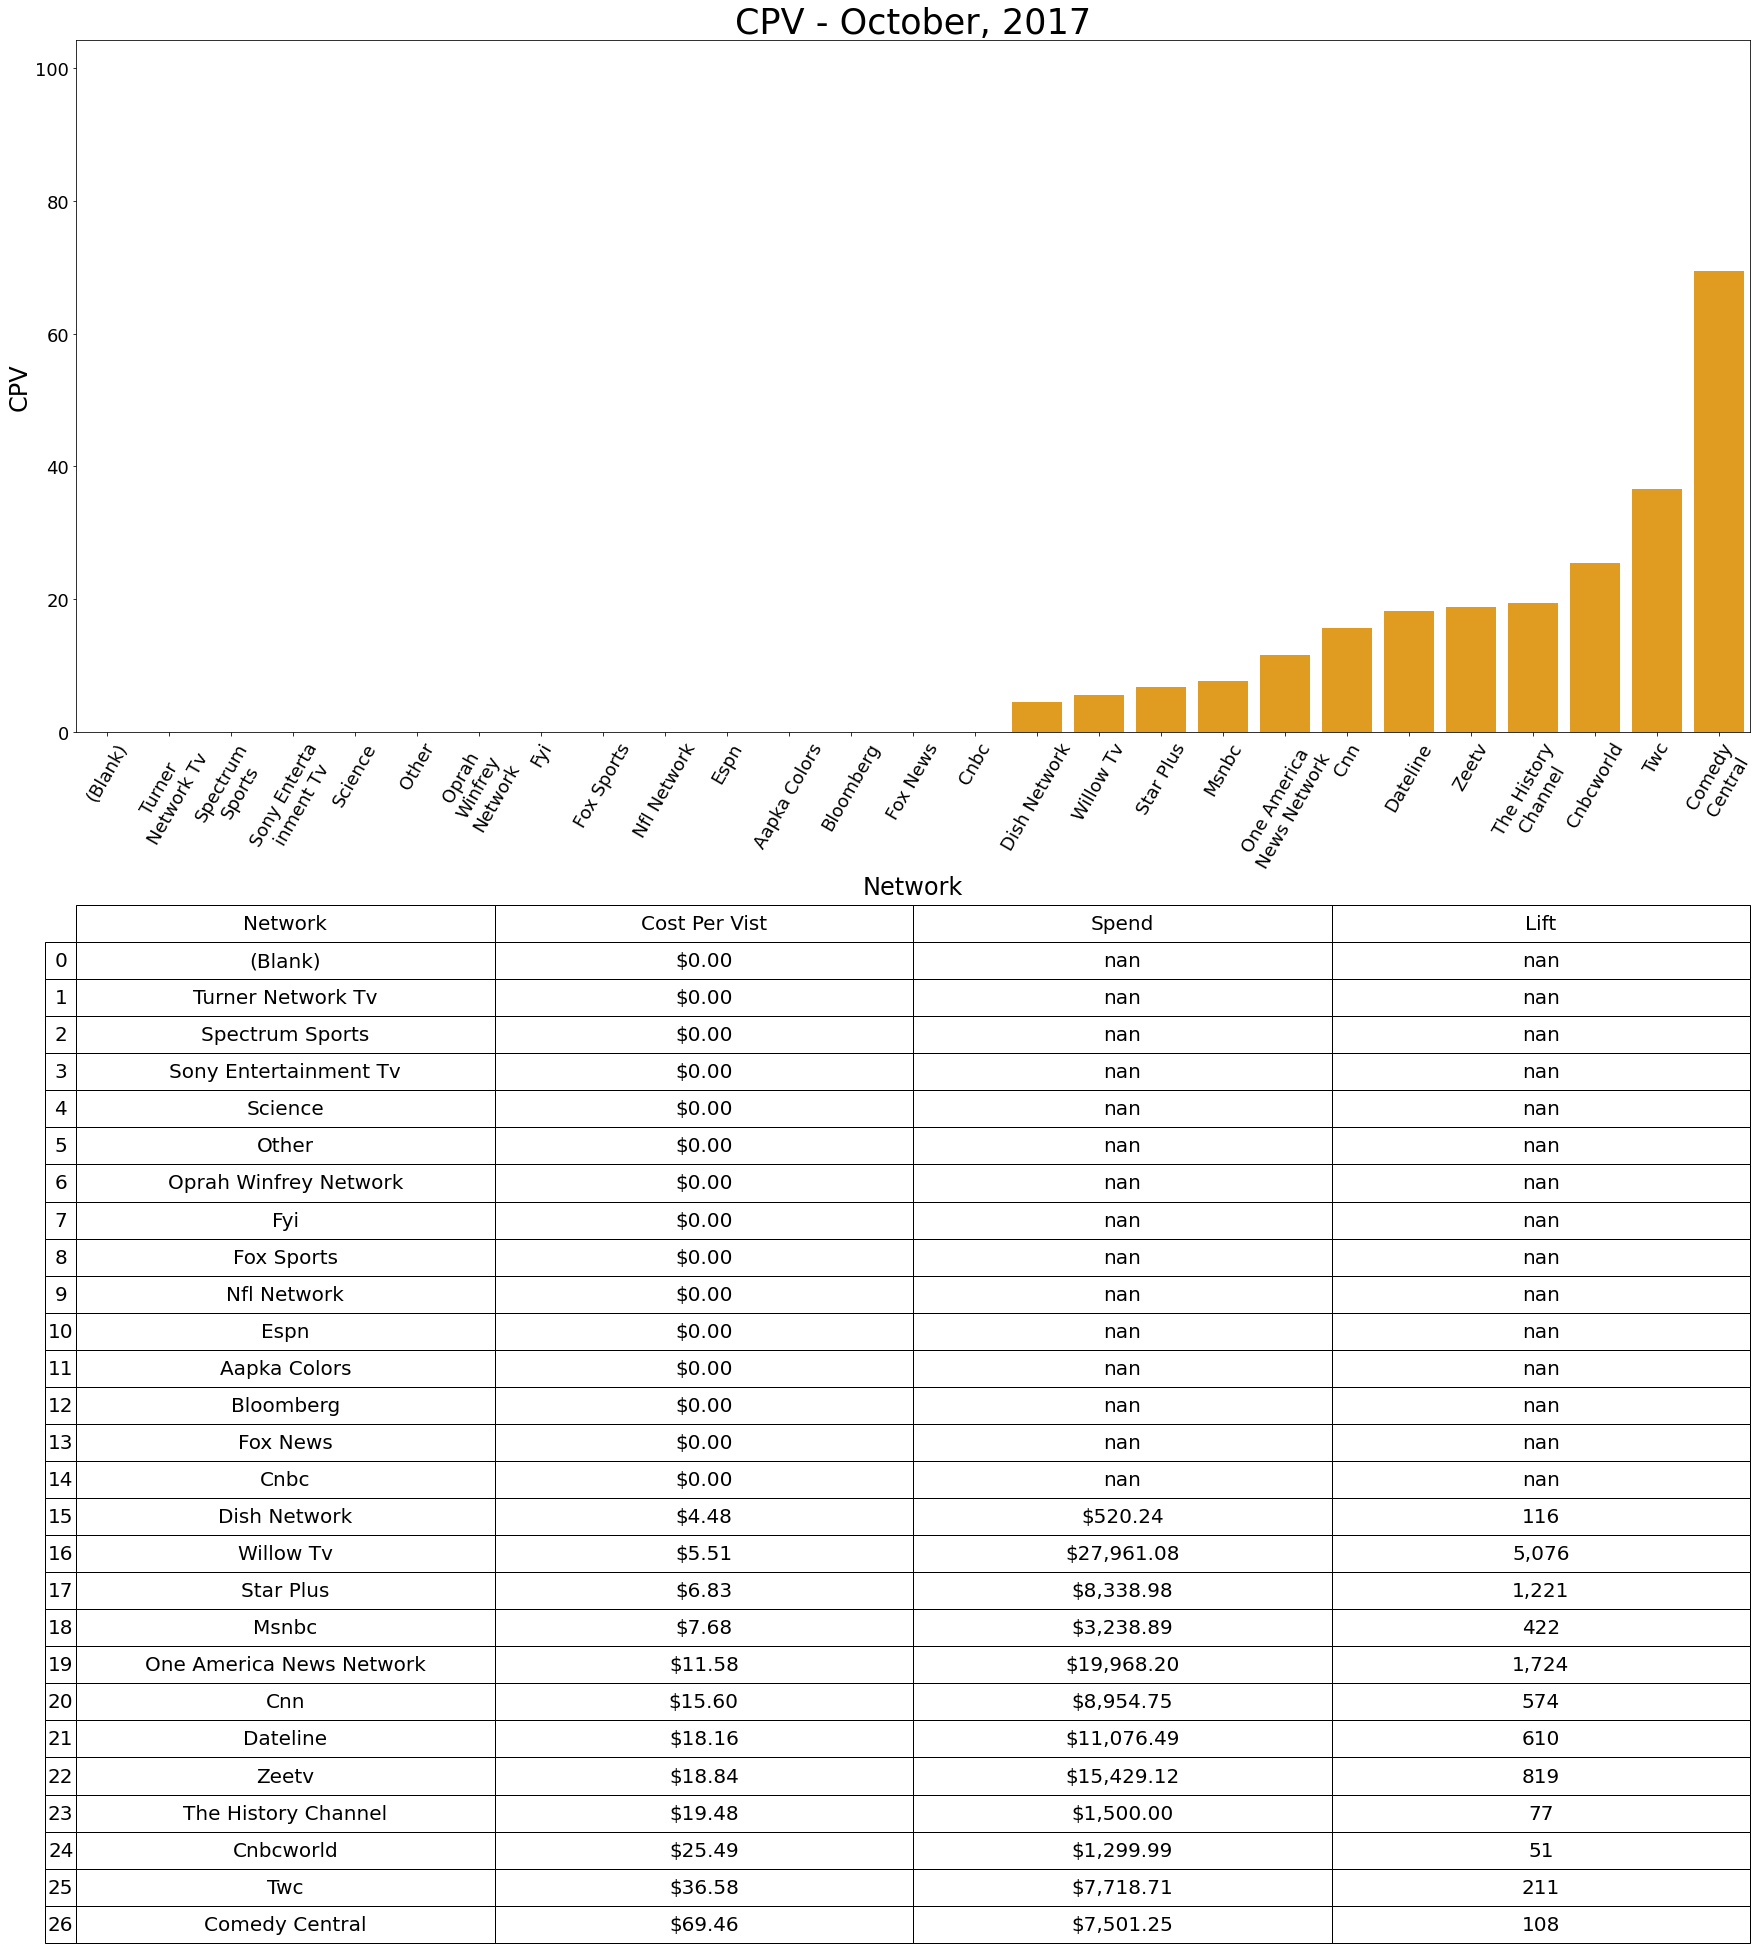

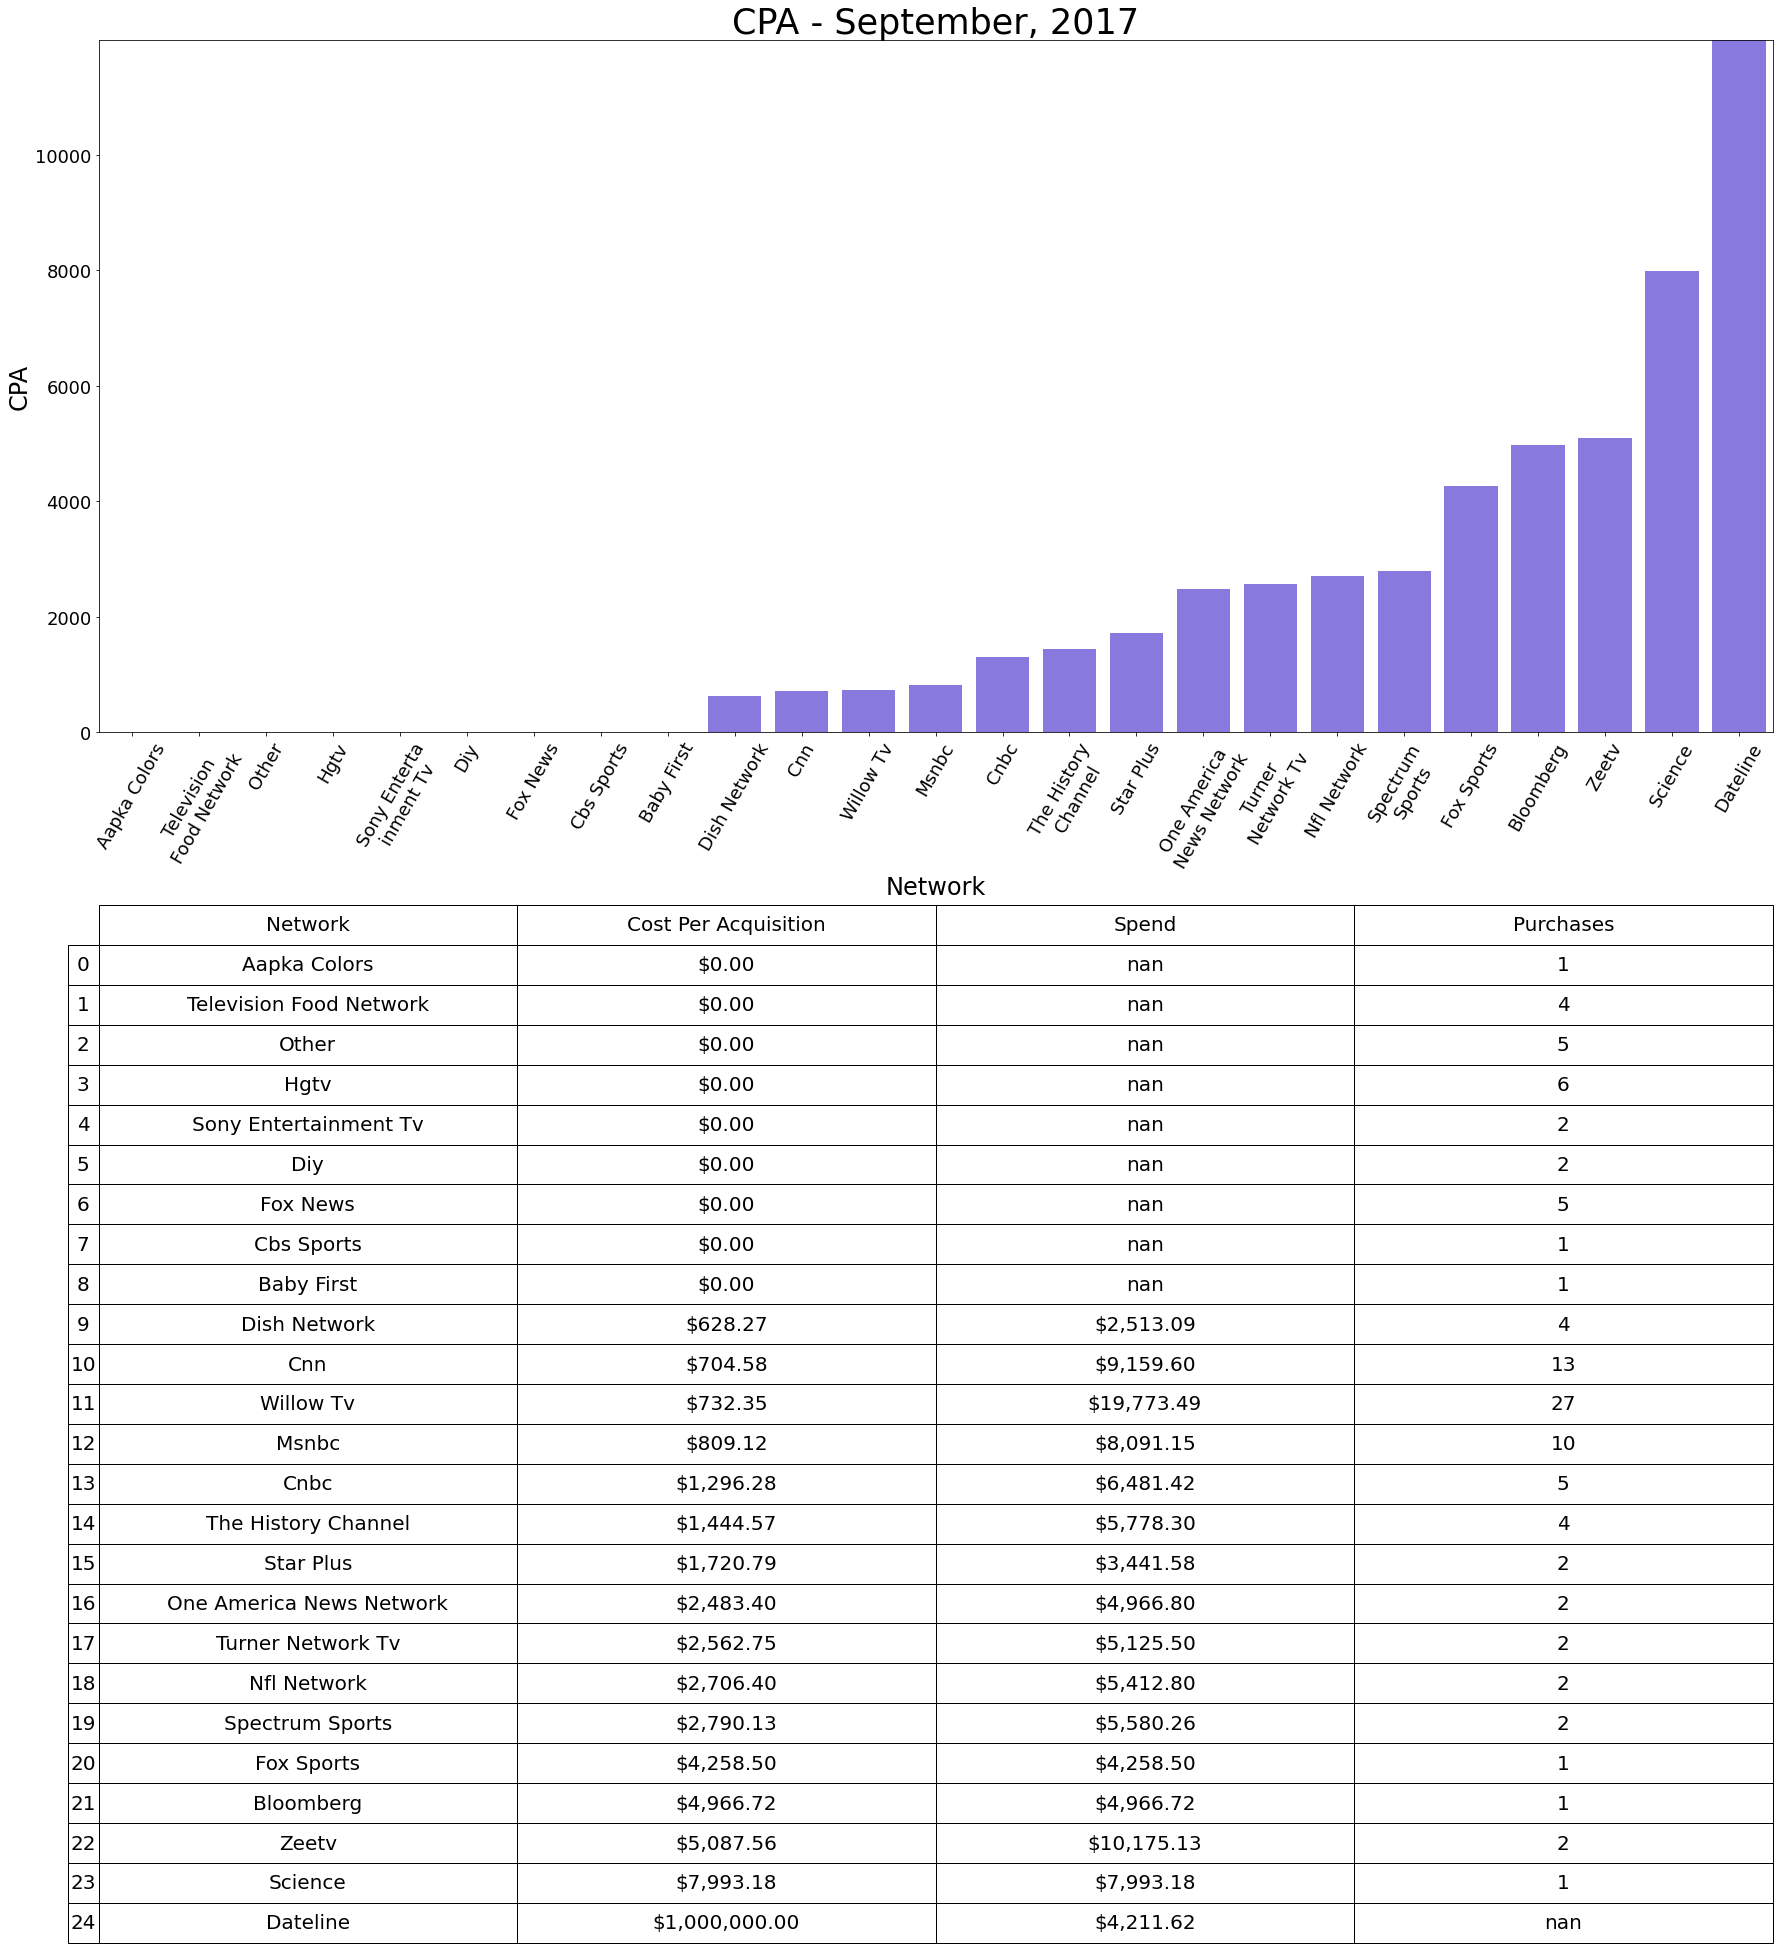

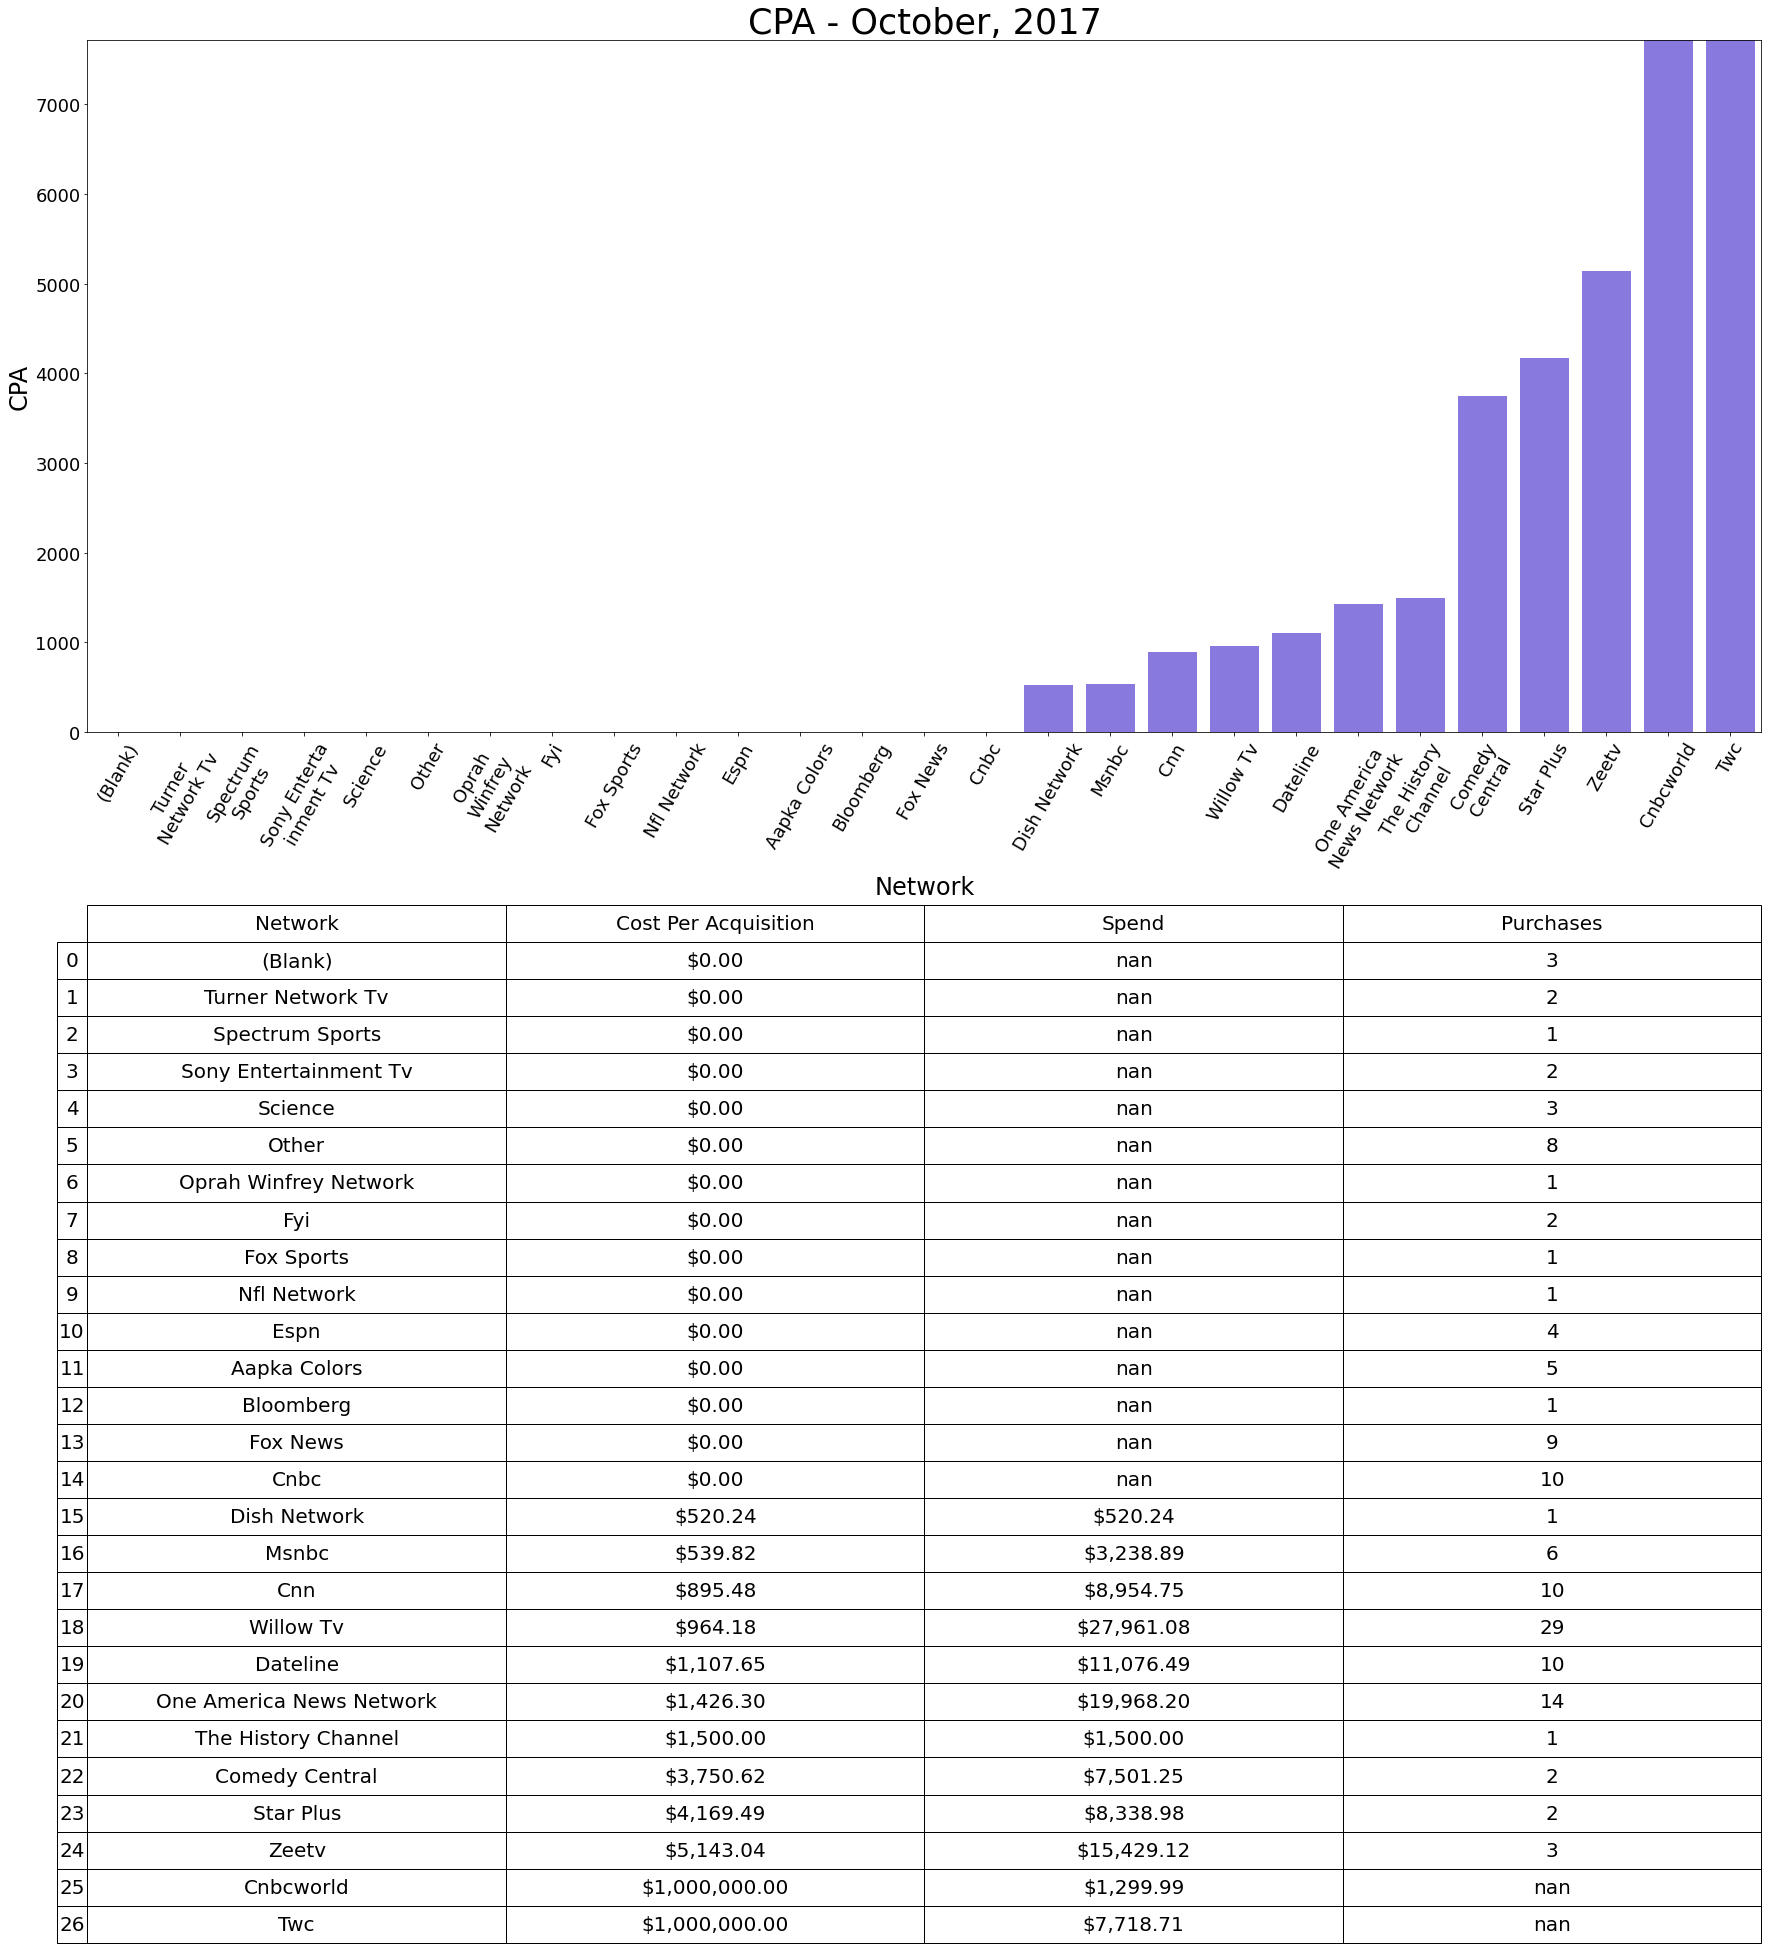

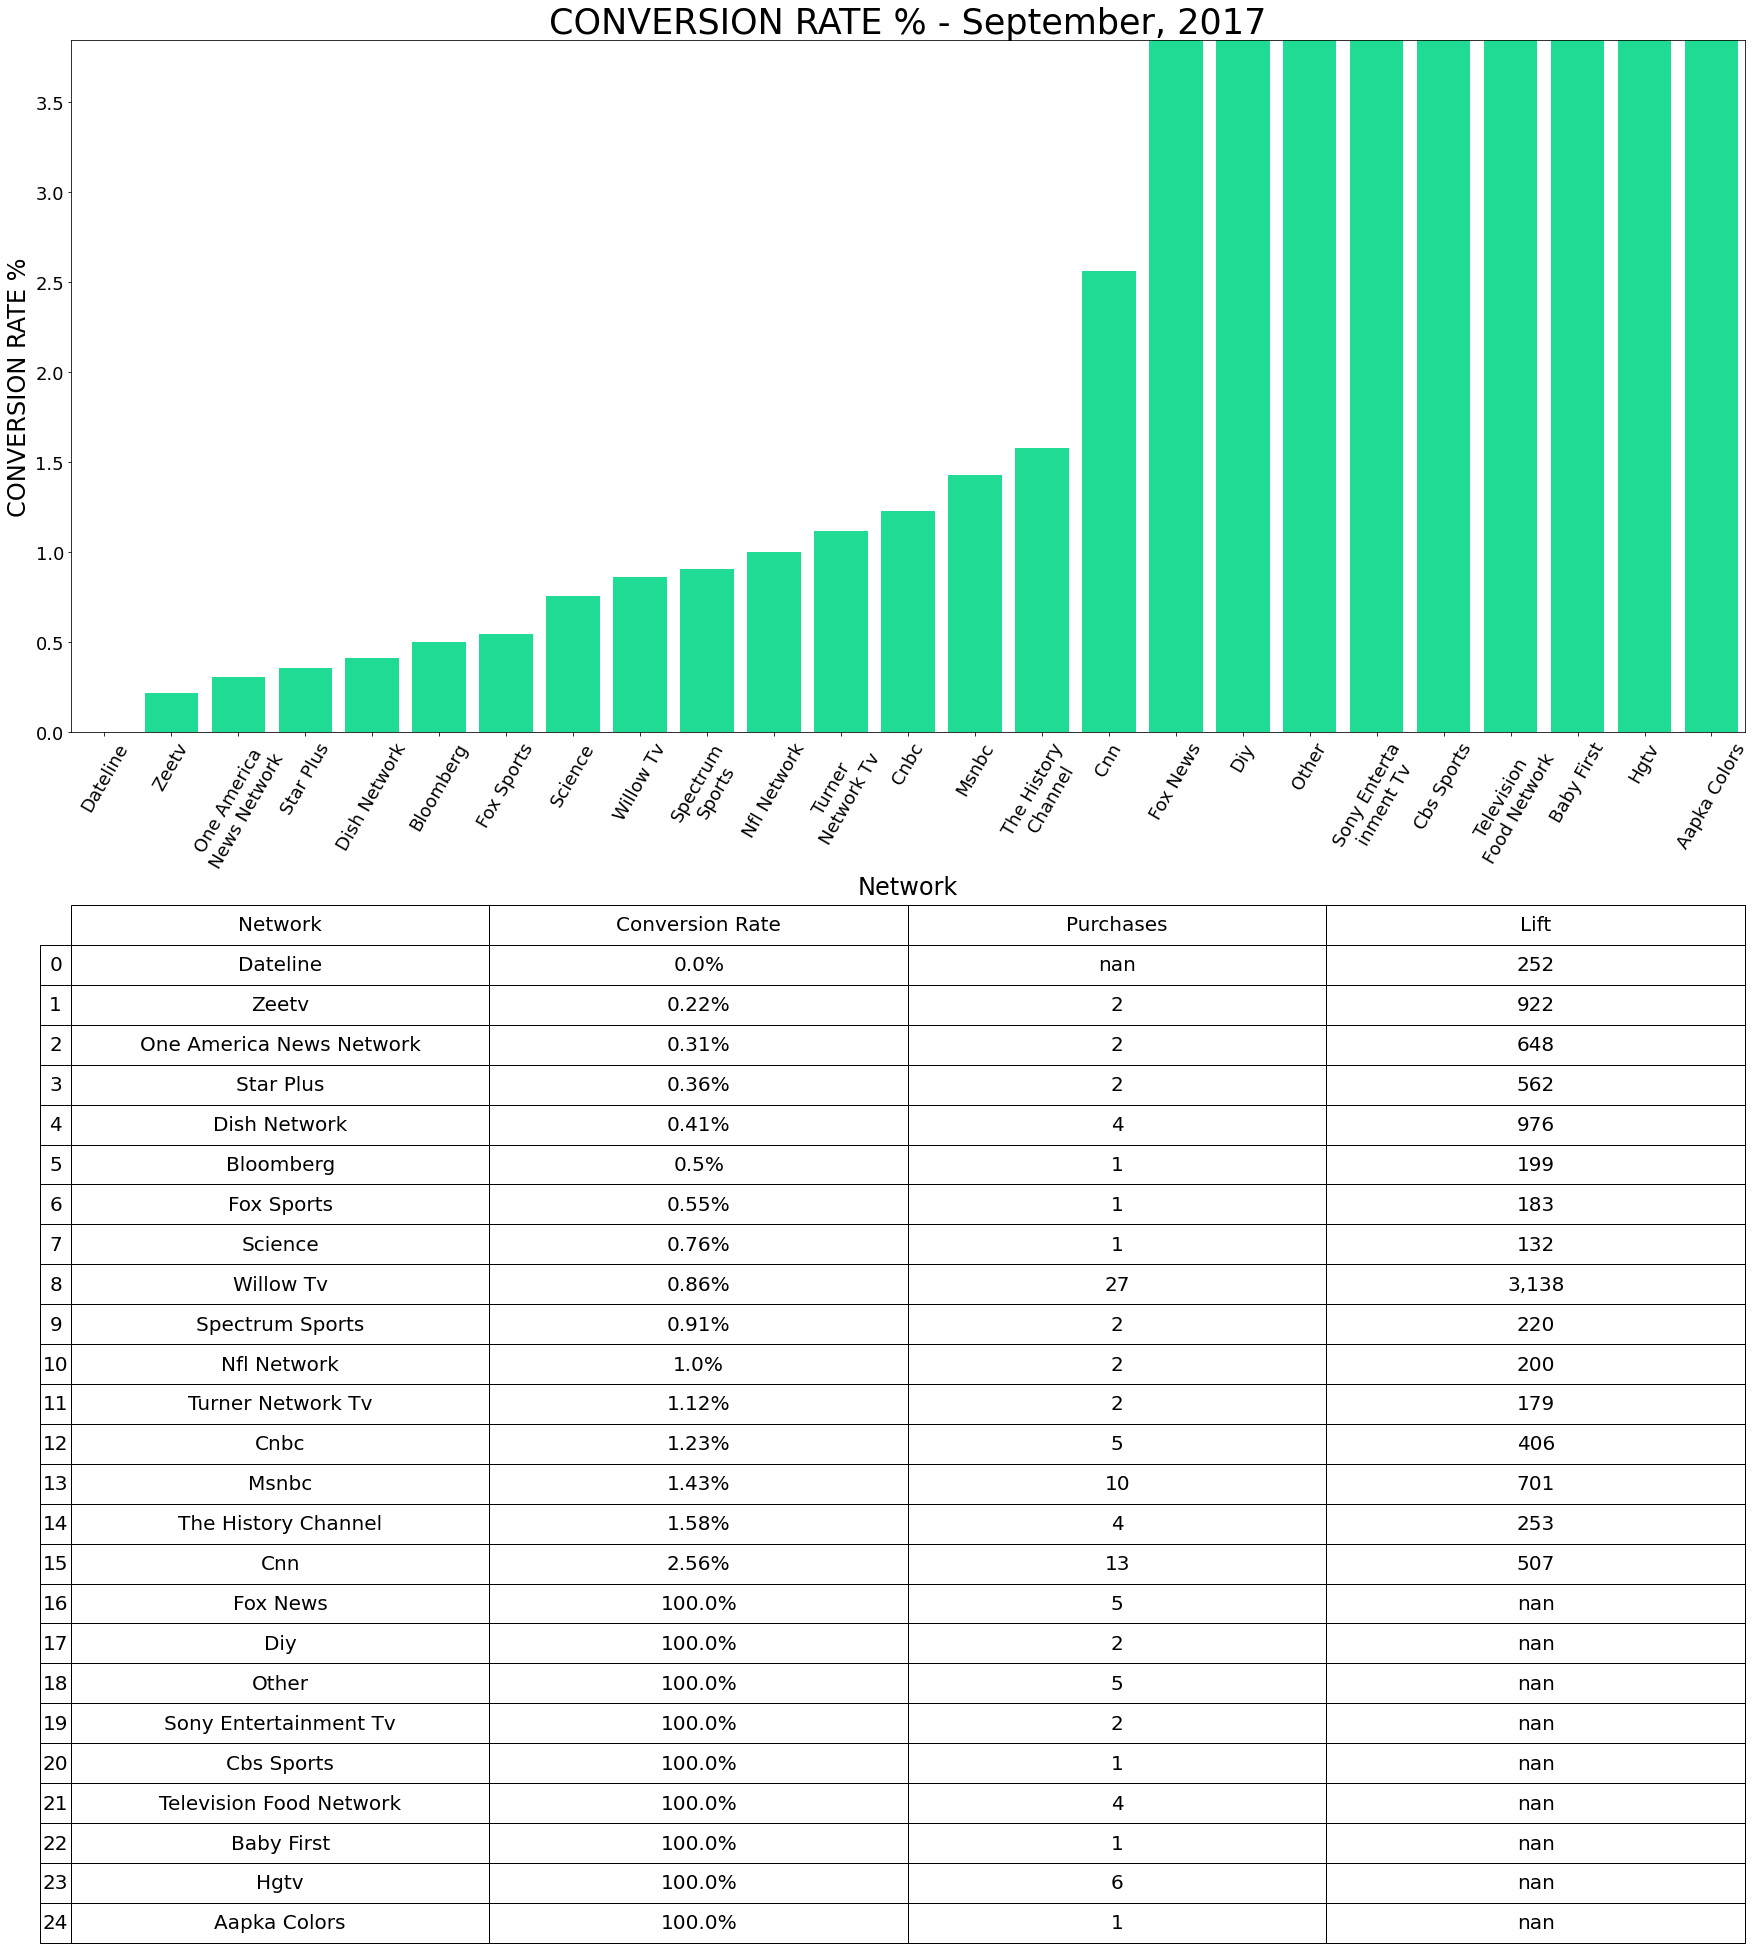

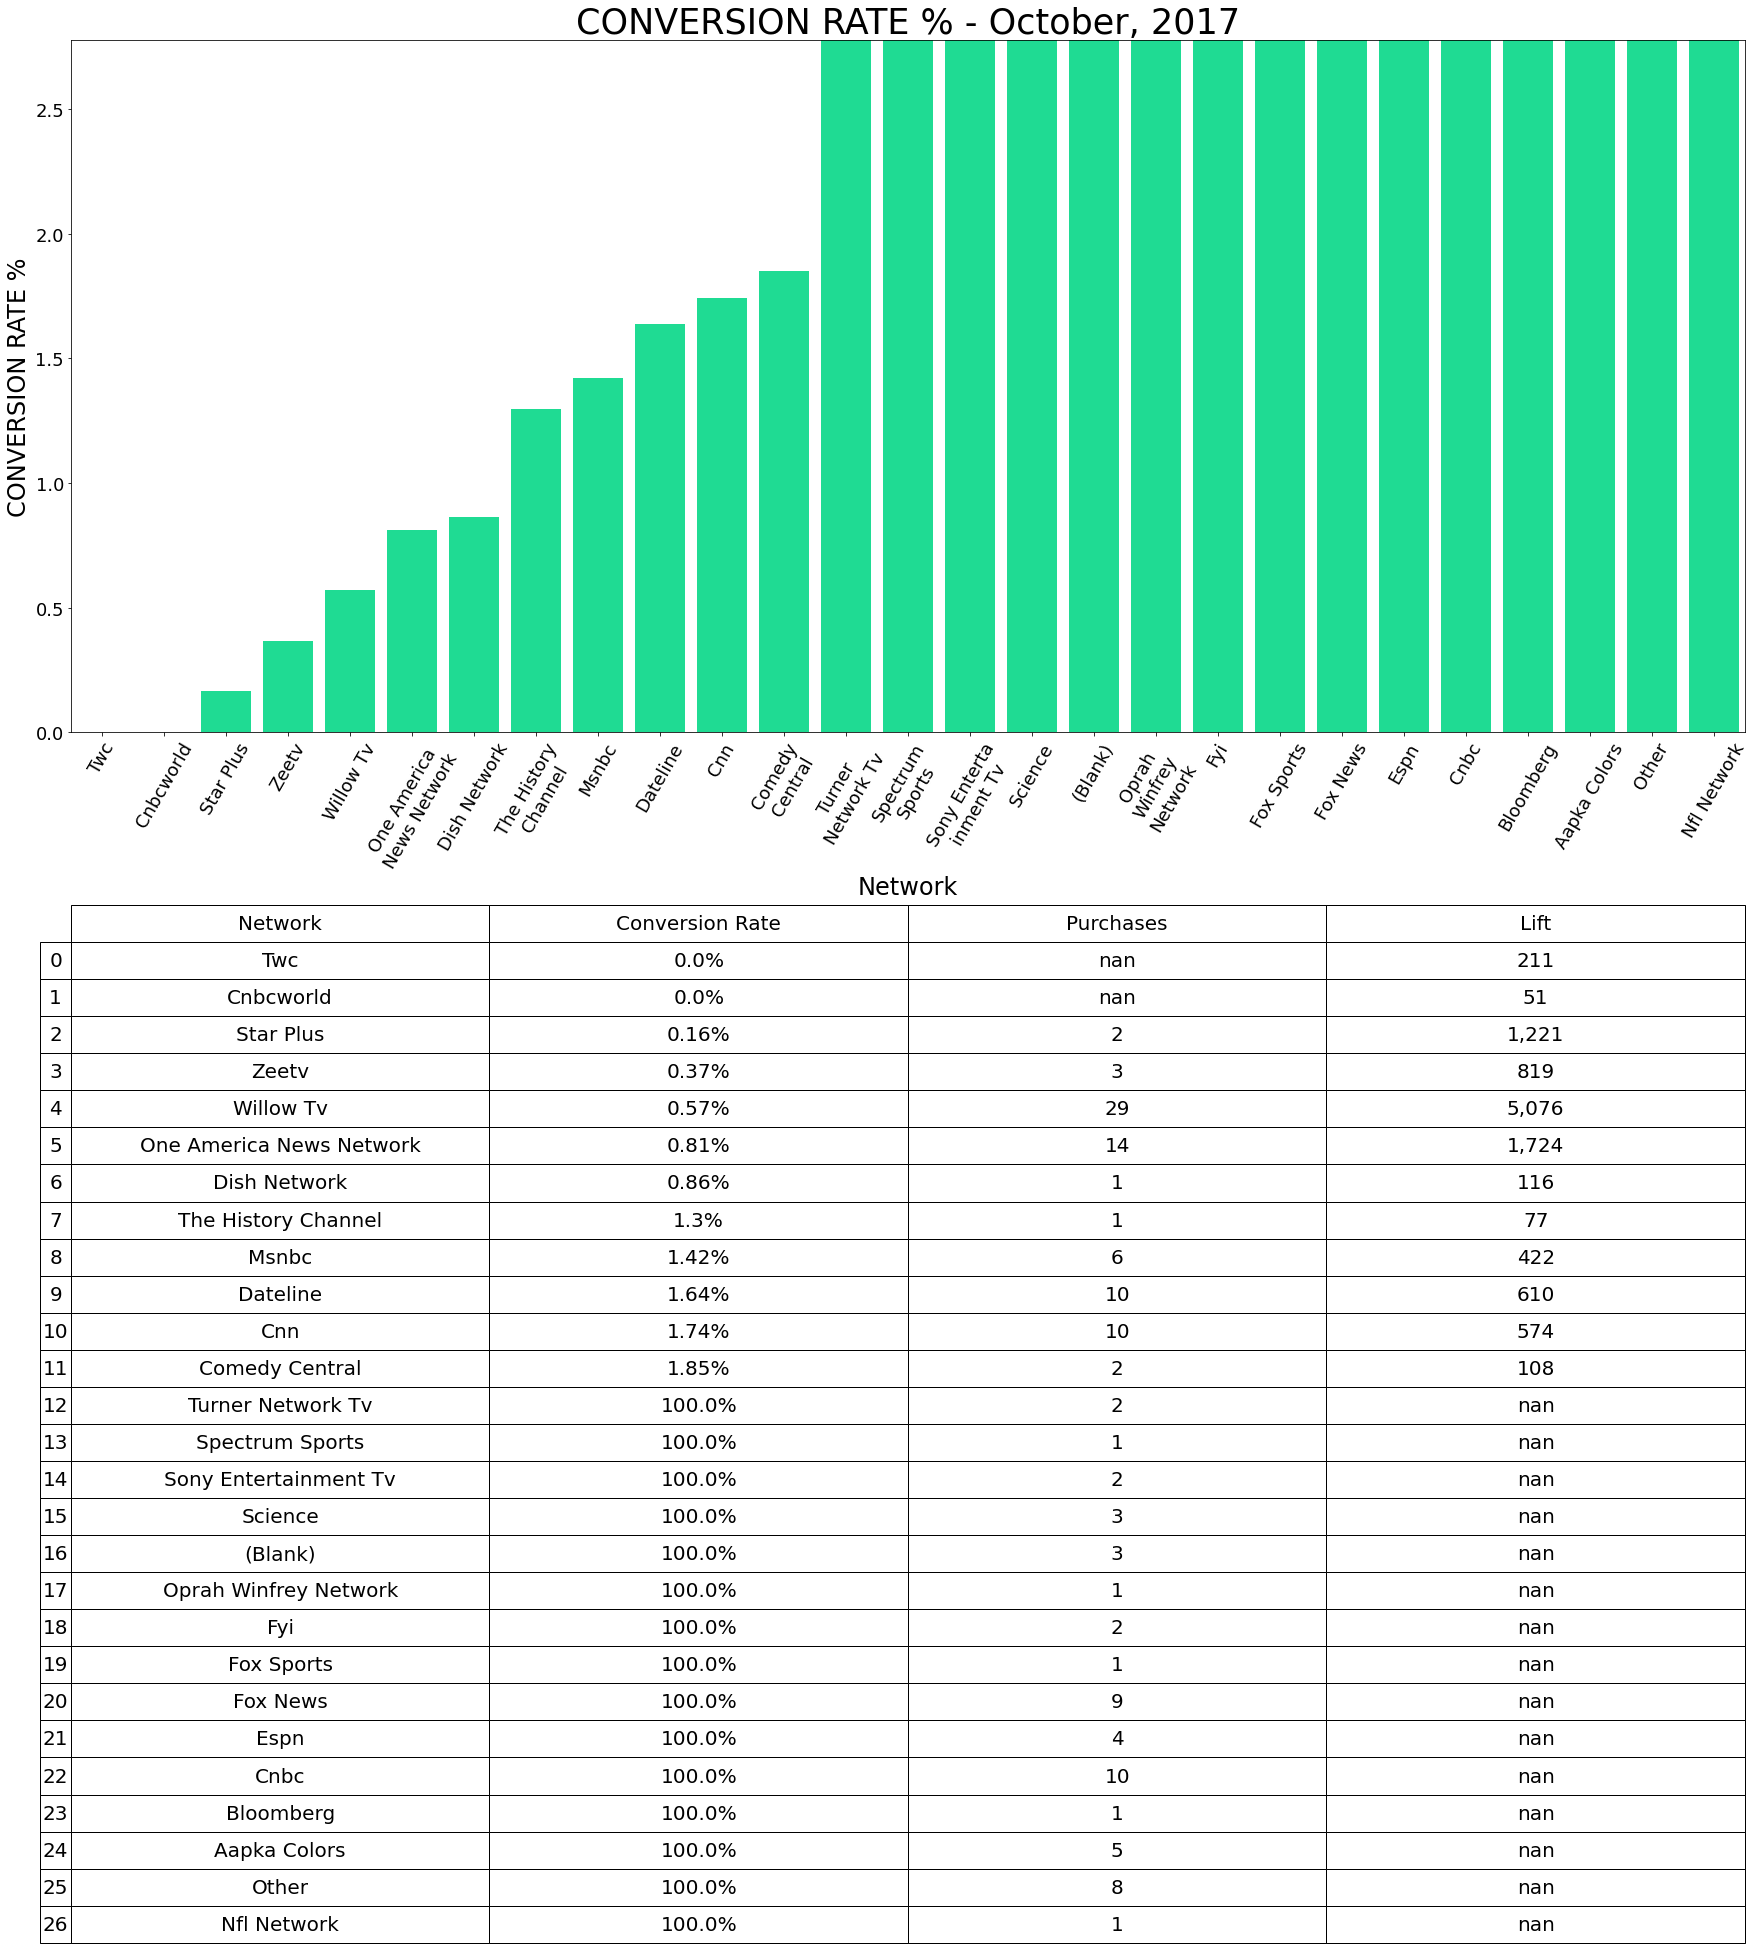

In [19]:
test.print_visuals(['cpv','cpa','conversion_rate'])